## Imports and functions

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# modeling imports
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# evaluation imports
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

# NLP imports
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords

/pyenvs/admission-prediction/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_model(X_train, y_train, model, **model_params):

    assert X_train.shape[0] == y_train.shape[0]

    clf = model(**model_params)
    clf.fit(X_train, y_train)

    return clf


def get_prediction(X_test, trained_model):

    y_pred       = trained_model.predict(X_test)
    y_pred_proba = trained_model.predict_proba(X_test)[:, 1]

    return y_pred, y_pred_proba


def evaluate_results(y_pred, y_pred_prob, y_test):

    assert y_pred.shape[0] == y_pred_prob.shape[0] == y_test.shape[0]

    # get roc evaluations
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # plot the ROC curve
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    axs[0].legend(loc='best')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('ROC Curve')

    # plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot(ax=axs[1], cmap='Blues', colorbar=False)

    plt.tight_layout()
    plt.show()


## Loading the data

In [3]:
df_seh = pd.read_csv('/export/home/jmaathuis/Documents/Data/SEH_SEHREG/25-09-2023_SEH_SERHREG_processed2.csv', encoding='latin-1')
df_seh = df_seh.set_index('SEHID')
df_seh.drop(columns='KLACHT', inplace=True) # processed complaint column is in 'text' column
df_seh.drop(columns='Unnamed: 0', inplace=True)

In [4]:
df_lab = pd.read_csv('/export/home/jmaathuis/Documents/Data/LAB/25-09-2023_LAB_processed.csv')
df_lab = df_lab.set_index('SEHID')

In [5]:
# combine the dataframes
df = df_seh.join(df_lab, on='SEHID', how='left')
df = df.fillna(-1)

In [6]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='BESTEMMING'), df['BESTEMMING'], test_size=.2, random_state=0)
X_train_all, X_test_all, y_train_all, y_test_all = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

## Fusion techniques

### Late fusion

In [7]:
## get the different input streams
# train
text_train = X_train.pop('text')
seh_train  = X_train.iloc[:,:56]
lab_train  = X_train.iloc[:,56:]

# test
text_test = X_test.pop('text')
seh_test  = X_test.iloc[:,:56]
lab_test  = X_test.iloc[:,56:]

results = {}

#### SEH

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


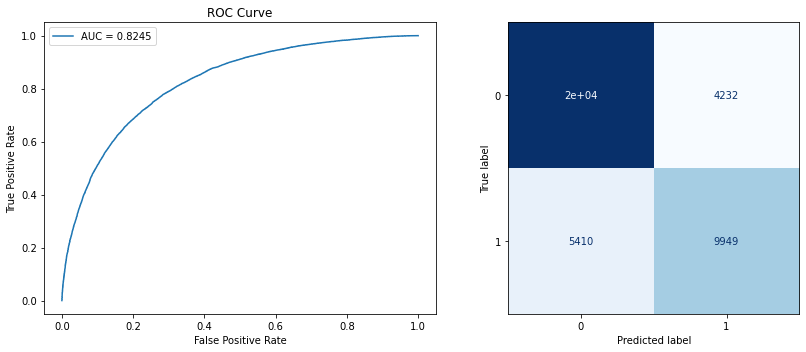

In [8]:
results['SEH'] = {}

clf = train_model(seh_train, y_train, xgb.XGBClassifier, objective="binary:logistic", random_state=0, eval_metric='logloss')
y_pred, y_pred_proba = get_prediction(seh_train, clf)
results['SEH']['TRAIN'] = y_pred_proba
y_pred, y_pred_proba = get_prediction(seh_test, clf)
results['SEH']['TEST'] = y_pred_proba
evaluate_results(y_pred, y_pred_proba, y_test)

#### TEXT

In [9]:
dutch_stop_words = set(stopwords.words('dutch'))

vec = TfidfVectorizer(ngram_range=(1, 6), stop_words=dutch_stop_words)

text_train = vec.fit_transform(text_train.astype(str))
text_test  = vec.transform(text_test.astype(str))

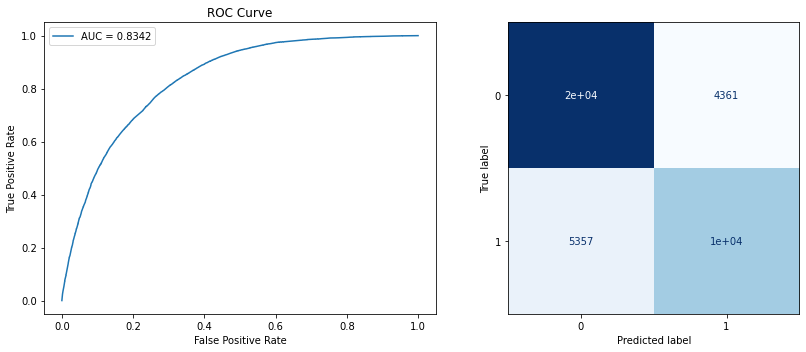

In [10]:
results['TEXT'] = {}

clf = train_model(text_train, y_train, LogisticRegression, max_iter=1e3)
y_pred, y_pred_proba = get_prediction(text_train, clf)
results['TEXT']['TRAIN'] = y_pred_proba
y_pred, y_pred_proba = get_prediction(text_test, clf)
results['TEXT']['TEST'] = y_pred_proba
evaluate_results(y_pred, y_pred_proba, y_test)

#### LAB

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


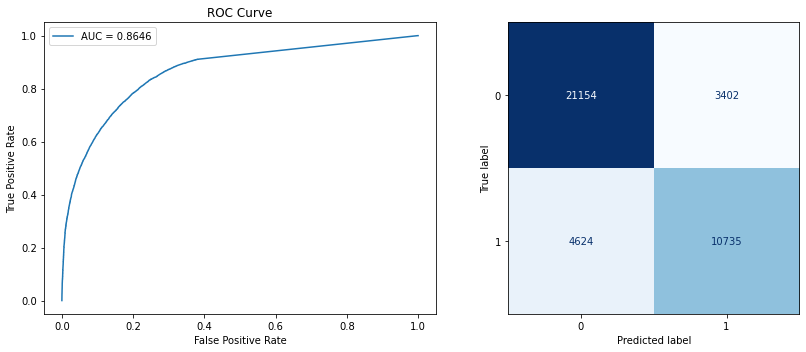

In [11]:
results['LAB'] = {}

clf = train_model(lab_train, y_train, xgb.XGBClassifier, objective="binary:logistic", random_state=0, eval_metric='logloss', booster='dart')
y_pred, y_pred_proba = get_prediction(lab_train, clf)
results['LAB']['TRAIN'] = y_pred_proba
y_pred, y_pred_proba = get_prediction(lab_test, clf)
results['LAB']['TEST'] = y_pred_proba
evaluate_results(y_pred, y_pred_proba, y_test)

#### FUSION

##### Weighted average

In [12]:
def get_weighted_average(input1, w1, input2, w2, input3, w3):
    return (input1 * w1 + input2 * w2 + input3 * w3) / sum([w1, w2, w3])

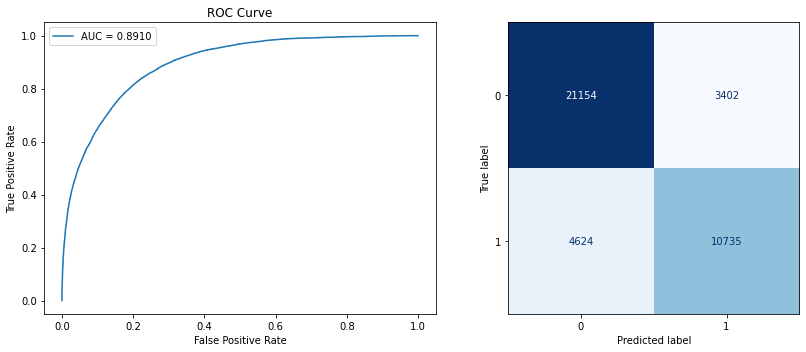

In [13]:
y_pred_proba = get_weighted_average(results['SEH']['TEST'], 1.2, results['TEXT']['TEST'], 0.8, results['LAB']['TEST'], 1.5)
evaluate_results(y_pred, y_pred_proba, y_test)

##### Meta-model

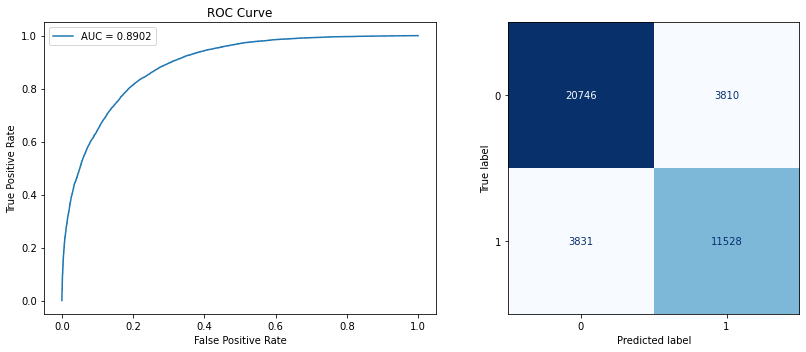

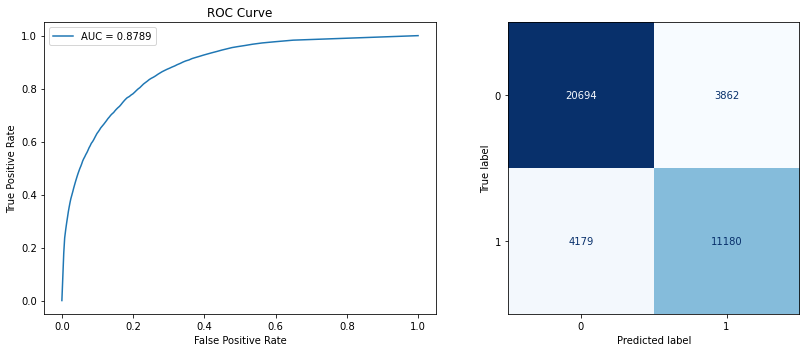

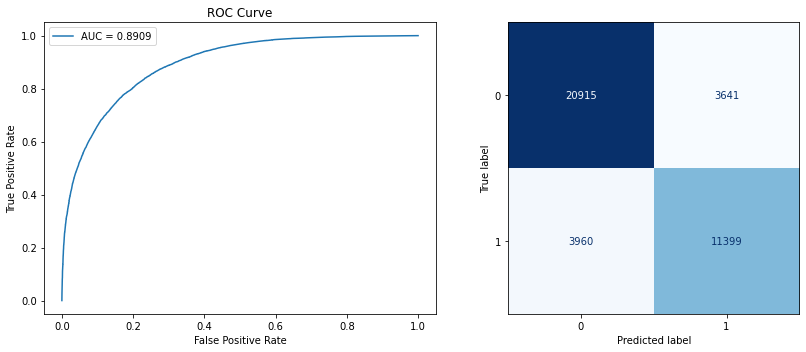

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:38:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


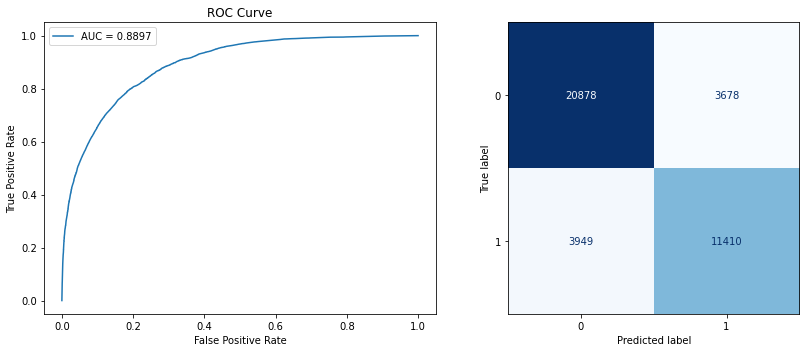

In [14]:
meta_train = pd.DataFrame({k: results[k]['TRAIN'] for k, v in results.items()})
meta_test = pd.DataFrame({k: results[k]['TEST'] for k, v in results.items()})

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

for model in (LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, xgb.XGBRFClassifier):
    clf = train_model(meta_train, y_train, model)#, objective="binary:logistic", random_state=0, eval_metric='logloss', booster='dart')
    y_pred, y_pred_proba = get_prediction(meta_test, clf)
    evaluate_results(y_pred, y_pred_proba, y_test)

### Early Fusion

In [15]:
dutch_stop_words = set(stopwords.words('dutch'))

vec = TfidfVectorizer(ngram_range=(1, 6), stop_words=dutch_stop_words, max_features=1000)

klacht_train = vec.fit_transform(X_train_all['text'].astype(str))
klacht_test  = vec.transform(X_test_all['text'].astype(str))

klacht_train = pd.DataFrame(klacht_train.toarray(), columns=vec.get_feature_names())
klacht_test  = pd.DataFrame(klacht_test.toarray(), columns=vec.get_feature_names())

X_train_all = pd.concat([X_train_all, klacht_train], axis=1)
del klacht_train
X_test_all  = pd.concat([X_test_all, klacht_test], axis=1)
del klacht_test

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


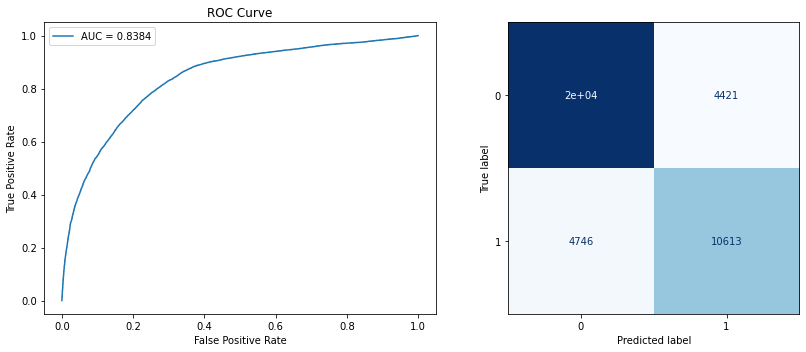

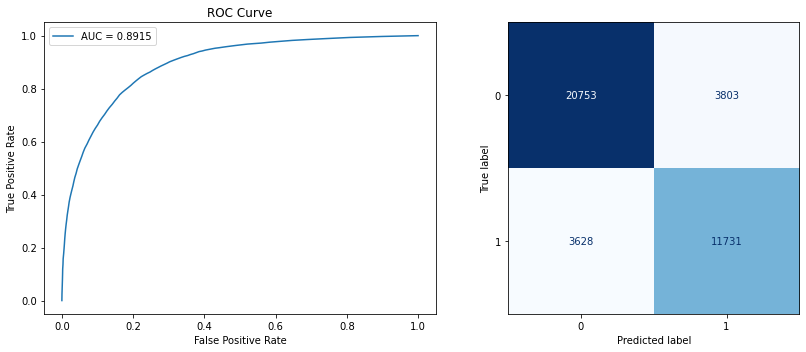

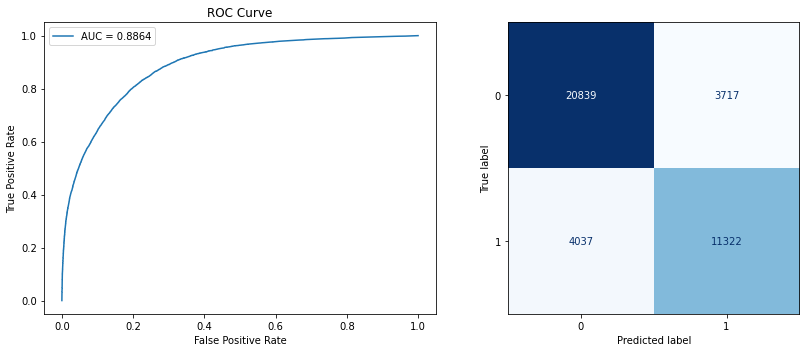

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:39:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


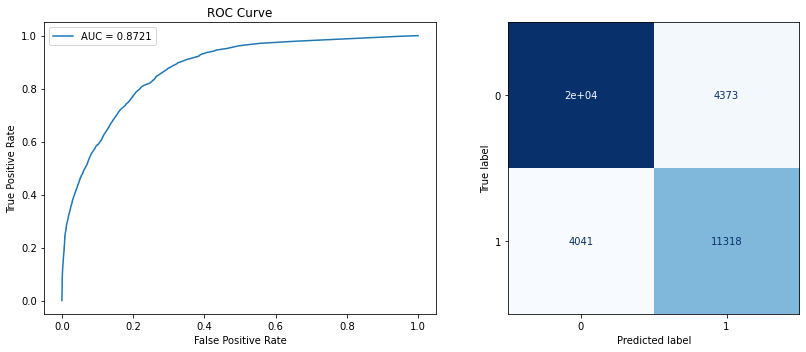

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:39:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


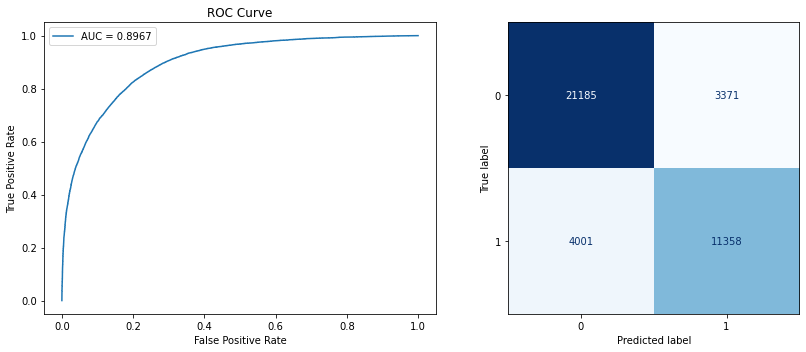

In [16]:
for model in (LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, xgb.XGBRFClassifier, xgb.XGBClassifier):
    clf = train_model(X_train, y_train, model)#, objective="binary:logistic", random_state=0, eval_metric='logloss', booster='dart')
    y_pred, y_pred_proba = get_prediction(X_test, clf)
    evaluate_results(y_pred, y_pred_proba, y_test)

### Combined Fusion

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


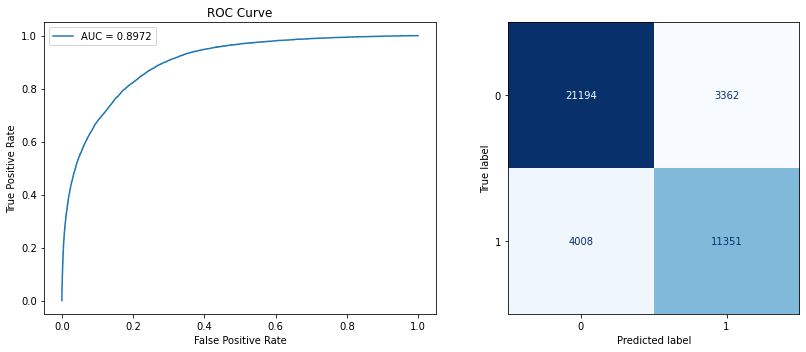

In [18]:
seh_train['LEEFTIJD'] = pd.cut(seh_train['LEEFTIJD'], bins= [i for i in range(0, 120, 5)] + [float('inf')], labels=range(24), right=False)
seh_test['LEEFTIJD']  = pd.cut(seh_test['LEEFTIJD'], bins= [i for i in range(0, 120, 5)] + [float('inf')], labels=range(24), right=False)

seh_train['LEEFTIJD'] = seh_train['LEEFTIJD'].astype(int)
seh_test['LEEFTIJD'] = seh_test['LEEFTIJD'].astype(int)

num_train = pd.concat([seh_train, lab_train], axis=1)
num_test  = pd.concat([seh_test, lab_test], axis=1)

class_counts = y_train.value_counts()
total_samples = len(y_train)
class_weights = {0: total_samples / (2 * class_counts[0]), 1: total_samples / (2 * class_counts[1])}

clf = train_model(num_train, y_train, xgb.XGBClassifier, objective="binary:logistic", random_state=0, eval_metric='auc')
y_pred_num, y_pred_proba_num = get_prediction(num_test, clf)
evaluate_results(y_pred_num, y_pred_proba_num, y_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


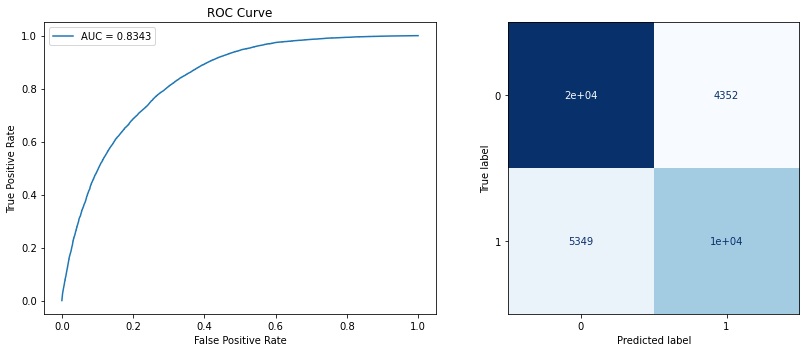

In [19]:
clf = train_model(text_train, y_train, LogisticRegression)
y_pred_text, y_pred_proba_text = get_prediction(text_test, clf)
evaluate_results(y_pred_text, y_pred_proba_text, y_test)

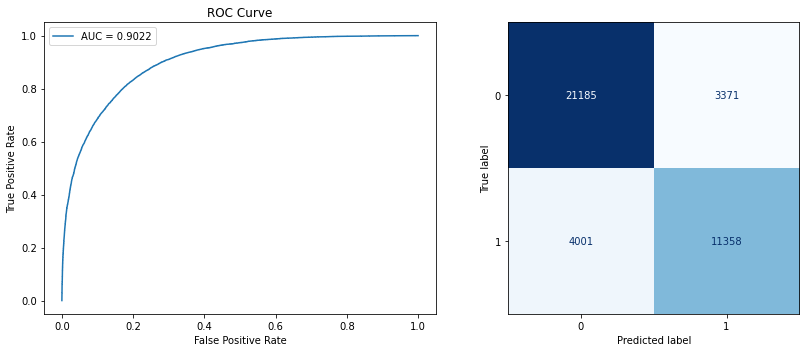

In [20]:
wa = get_weighted_average(y_pred_proba_num, 1.5, y_pred_proba_text, 0.5, 0, 0)
evaluate_results(y_pred, wa, y_test)